# Projet IA -- clustering

In [126]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from IPython.core.display import Image, display
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from plot_sklearn_dendrogram import plot_sklearn_dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
import graphviz 
from sklearn import tree
%matplotlib inline
np.random.seed(10)
random.seed(10)
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing # to scale data
from sklearn.metrics import silhouette_score
from pandas.plotting import parallel_coordinates

## Définition des fonctions

In [2]:
# 3D plot using pyplot
def plot_km3d(km,df):
    """km est un objet de Kmeans. df est le dataframe correspondant sur lequel on a fait l'analyse."""
    fig = plt.figure() #opens a figure environment
    ax = Axes3D(fig) #to perform a 3D plot
    x=df.loc[:,'CO2']
    y=df.loc[:,'Population']
    z=df.loc[:,'Life_expectancy']
    ax.scatter(x, y, z,c=km.labels_.astype(np.float)) #plot definition and options 
    ax.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],km.cluster_centers_[:,2],c='r',s=100)
    # We set the colors to be in function of the labels of each cluster, ie each category
    # Cluster centers are in red
    ax.set_xlabel('CO2')
    ax.set_ylabel('Population')
    ax.set_zlabel('Life_expectancy')

In [3]:
def plot_dendro_km(df,km):
    """Plots the dendrogram for a specified clustering km and a table df.
    Returns the Agglomerative clustering object."""
    DF_Dendro1 = df.copy(deep=True)
    agc = AgglomerativeClustering(n_clusters=len(km.cluster_centers_), affinity="euclidean", linkage="complete")
    agc.fit(DF_Dendro1)
    plt.title('Hierarchical Clustering Dendrogram')
    plot_sklearn_dendrogram(agc, labels=agc.labels_)
    plt.show()
    return agc

In [4]:
def kmeans_SSE(df):
    """Plots SSE evolution for different clusters numbers (from 1 to 15) for a dataframe df."""
    sse = []
    Ks = range(1, 15)
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
        km.fit(df)
        sse.append(km.inertia_)
    plt.plot(Ks,sse)
    plt.xlabel("$k$",fontsize=20)
    plt.ylabel("SSE",fontsize=14)
    return sse

In [83]:
def silhouette_kmeans(df):
    """Plots Silhouette coefficient evolution for different values of k (clusters number)."""
    silhouette_coef = []
    Ks = range(2, 30)
    for k in Ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    plt.plot(Ks,silhouette_coef)
    plt.xlabel("$k$",fontsize=20)
    plt.ylabel("Silhouette Coef.",fontsize=14)

In [110]:
def silhouette_dbscan(df,minpts,min_knee):
    """Plots Silhouette coefficient evolution for different values of eps with a specified minpts parameter.
    Min_knee is the above limit value for eps.
    If one cluster (or only one cluster + noise points), silhouette arbitrary set to 0."""
    silhouette_coef = []
    Eps = np.arange(0.01,min_knee,0.01)
    for e in Eps:
        db = DBSCAN(min_samples=minpts,eps=e)
        db.fit(df)
        labels = db.labels_
        if len(set(labels))>2: 
            silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
        else:
            silhouette_coef.append(0)
    plt.plot(Eps,silhouette_coef)
    plt.xlabel("$eps$",fontsize=20)
    plt.ylabel("Silhouette Coef.",fontsize=14)

In [6]:
def stability_kmeans(df,ki):
    silhouette_coef = []
    sse = []
    k = ki
    n_init=1
    for i in range(100):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        sse.append(km.inertia_)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    ax1=plt.subplot(2, 2, 1)
    ax1.hist(sse)
    ax1.set_xlabel("SSE")
    ax2=plt.subplot(2, 2, 2)
    ax2.hist(silhouette_coef)
    ax2.set_xlabel("Silhouette")
    plt.show()

In [7]:
def plot_stability(df):
    stability = []
    Ks = range(2,30)
    for k in Ks:
        stability.append(compute_stability(k,df))
    plt.plot(Ks,stability,"o-")
    plt.xlabel("$k$",fontsize=20)
    plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")
    plt.show()

In [8]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(silhouette_score(df, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

## Importation des données

In [9]:
df = pds.read_csv('./Data2/Data2.txt', sep="\t") # load a pandas dataframe from csv
df.head()

,Time,Time Code,Country Name,Country Code,Children out of school,CO2 emissions (kt),Non-renewable lectricity production (% of total),Renewable electricity production excluding hydroelectric (% of total),Life expectancy (years),Population,Rural population,Urban population,Surface area (sq. km)
0,2013,YR2013,Afghanistan,AFG,NaN,10014.577,NaN,NaN,62.494,31731688.0,23997724.0,7733964.0,652860.0
1,2013,YR2013,Albania,ALB,10957.0,5064.127,0.00000,0.0,77.702,2895092.0,1291587.0,1603505.0,28750.0
2,2013,YR2013,Algeria,DZA,NaN,134465.223,99.44899,0.0,75.418,38338562.0,11664124.0,26674438.0,2381740.0
3,2013,YR2013,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,55307.0,6997.0,48310.0,200.0
4,2013,YR2013,Andorra,AND,NaN,476.710,NaN,NaN,NaN,80788.0,9261.0,71527.0,470.0


## Description

Les données rassemblent trois grands types de variables : <br>
- Des données environnementales (Ex  : émissions de CO2, production d'énergie verte...)
- Des données de développement (accès à l'éducation, expérance de vie)
- Des données démographiques fondamentales (population totale, rurale, urbaine...)
- Des données géographique (superficie)

## Description des variables

* Colonne n°1 : Time => Année de l'étude
* Colonne n°2 : Time code
* Colonne n°3 : Contry name => pays étudiés
* Colonne n°4 : Country code


* Colonne n°5 : Children out of school, primary <br>
Nombre d'enfants de l'âge de l'école du primaire non scolarisés

<!-- ![Title](Children_Out_of_primary_school.png "Nombre d'enfants  (en million )d'âge du primaire non scolarisés entre 1970 et 2017") -->

* Colonne n°6 : CO2 emissions (kt) <br>
Emissin en CO2 en kilotonnes

![Title](EmissionCO22013.png)
*Rmq : On pourrait considérer cette variable en fonction du nombre total d'habitant par pays?*

* Colonne n°7 : Electricity production from oil, gas and coal sources (% of total) <br>
Pourcentage d'électricité produite via des ressources fossiles par rapport à la production totale d'électricité (données mondiales 2015)

![Title](Electricite_fossile2013.png)


* Colonne n°8 : Electricity production from renewable sources, excluding hydroelectric (% of total)
![Title](Electricite_verte_sauf_hydro_2013.png)

*Rmq : étonnante répartion, la production d'électricité verte ne semble pas liée au PIB (à démontrer)?*

* Colonne n°9 : Life expectancy at birth, total (years) 

* Colonne n°10 : Population, total 
* Colonne n°11 : Rural population 
* Colonne n°12 : Urban population 
* Colonne n°13 : Surface area (sq. km) 

<!--![Title](Poppulation_Urbaine_1960_2017.png)-->

*rmq : on incluera aussi le PIB dans une seconde étude.*

## Data cleaning

### Rename columns

In [10]:
df  = df.rename(index=str, columns={"Children out of school":"School", "CO2 emissions (kt)": "CO2" , "Non-renewable lectricity production (% of total)":"Fossile_electricity", "Renewable electricity production excluding hydroelectric (% of total)" : "Renewable_electricity", "Life expectancy (years)":"Life_expectancy" , "Rural population":"Rural" , "Urban population" : "Urban" ,"Surface area (sq. km)" : "Surface" } )

### Column cleaning

Un prétraitement des données nous a permis de conserver uniquement des attributs pour lesquels on a assez de données. Ainsi, on ne modifie pas les colonnes.

### Row cleaning 

In [11]:
filtered_df = df.dropna(subset=['CO2', 'Population','Life_expectancy']) 
# On enlève toutes les lignes qui contiennent des NA

## Sélection des données à analyser

In [12]:
df_clustering=filtered_df[['CO2','Population','Life_expectancy']]

## Normalisation des données

On analyse les données (pour savoir si on centre-réduit).
Ici, on va forcément centrer les données car les unités sont différentes.

### 1 - Centrage

(-50000000.0, 50000000.0)

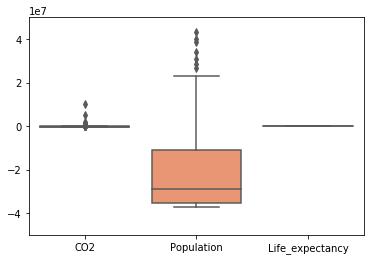

In [13]:
ax=sns.boxplot(data=(df_clustering - df_clustering.mean()), orient="v", palette="Set2")
ax.set_ylim(-0.5e8,0.5e8)

### 2- Réduction

(-2, 2)

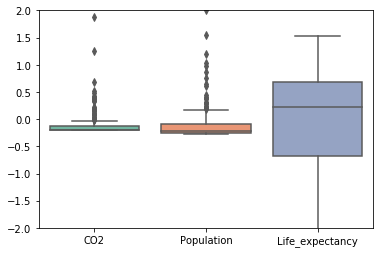

In [14]:
ax=sns.boxplot(data=(( df_clustering - df_clustering.mean() )/df_clustering.std()), orient="v", palette="Set2")
ax.set_ylim(-2,2)

In [15]:
df_clustering_red=(df_clustering - df_clustering.mean())/df_clustering.std()

## Repérage des outliers

On étudie déjà les outliers, avant d'exécuter l'algorithme des Kmeans. Pour cela nous allons utiliser DBSCAN, on considerera que les 'noise points' sont les outliers. Le problème est alors d'estimer les paramètres en entrée de DBSCAN : soit le nombre de points minimum devant se trouver dans un rayon donné, pour considérer un cluster. Pour le déterminer, nous allons tracer le graphique de la distance au quatrième voisin le plus proche en utilisant les données de KNN.

In [16]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(df_clustering_red)
distances, indices = nbrs.kneighbors(df_clustering_red)
distances_to_4 = distances[:,3]
distances_to_4 = sorted(distances_to_4 , reverse = False)

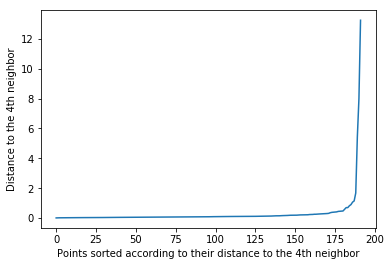

In [17]:
Index = range(0,len(distances_to_4))
plt.plot(Index , distances_to_4)
plt.xlabel('Points sorted according to their distance to the 4th neighbor')
t=plt.ylabel('Distance to the 4th neighbor')

In [18]:
mean_dist_knee = sum(distances_to_4[180:190])/10
mean_dist_knee

1.3527450344278238

Le graphique ci-desssus nous permet d'observer 'un coude'. Autrement dit la distance au quatrième voisin est relativement stable pour les 175 premières valeurs, puis augmente brusquement. 

### DBSCAN pour déterminer les outiers

Nous utiliserons la distance moyenne calculée au niveau du coude (mean_dist_knee ) comme paramètre de DBSCAN.

In [65]:
outliers_det = DBSCAN(min_samples=50,eps=mean_dist_knee).fit(df_clustering_red)
# Number of outliers
sum(outliers_det.labels_ == -1) 

4

D'après nos paramètres, nous repérons 4 outliers, ce qui peut largement être discuté ! 

#### Analyse des résultats de DBSCAN

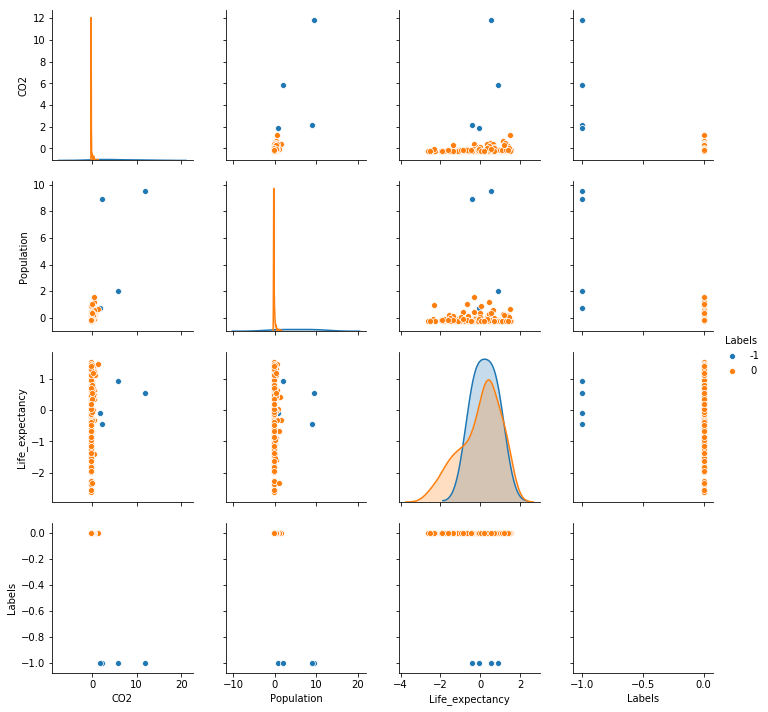

In [66]:
df_clustering_red_lab=df_clustering_red.copy(deep=True)
df_clustering_red_lab['Labels']=outliers_det.labels_
s=sns.pairplot(data=df_clustering_red_lab,hue='Labels') # les labels ne nous servent pas
# Les -1 permettent de repérer les outliers

D'après nos paramètres DBSCAN crée 2 groupes, et un cluster d'outliers constitué de 4 pays. Dans les pays exclus on retrouve la Chine et l'Inde à cause de leur grande population, mais aussi les Etats-Unis (gros taux de CO2) et la Russie (à cause du CO2 ?)

In [21]:
df_clustering_countries= df_clustering_red_lab.copy(deep=True) # Copy of DF_kmeans1
df_clustering_countries['Country'] = filtered_df['Country Name']

print(df_clustering_countries[df_clustering_countries['Labels'] == -1])

           CO2  Population  Life_expectancy  Labels             Country
41   11.810629    9.510340         0.549868      -1               China
89    2.178481    8.942533        -0.433087      -1               India
161   1.878397    0.765541        -0.083496      -1  Russian Federation
206   5.838196    2.009879         0.912599      -1       United States


## Une façon visuelle de déterminer les outliers

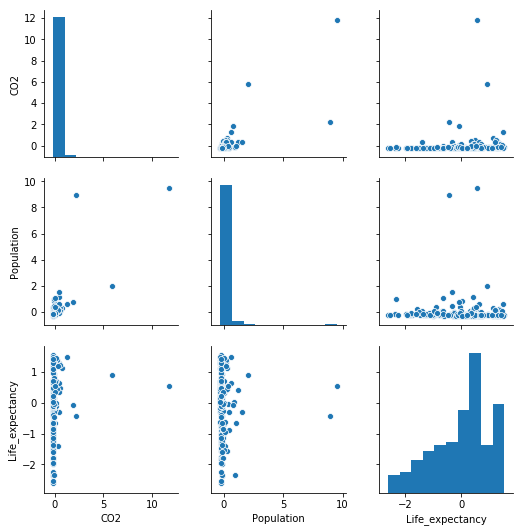

In [22]:
dfScatterPlot = sns.pairplot(data=df_clustering_red)

On remarque 7 points extrêmes pour la population et 5 pour le CO2. Cependant, il est difficile de les discriminer les outliers du reste visuellement.

In [23]:
# Outliers du CO2
df_CO2 = df_clustering_red.sort_values(by =['CO2'] , ascending = False)[5: ][ : ] # Remove Outliers

En traçant à nouveu le pairplot, on voit qu'il reste 6 outliers de population.

In [24]:
df_popCO2 = df_CO2.sort_values(by =['Population'] , ascending = False)[6: ][ : ] # Remove Outliers

Cette méthode a enlevé 11 outliers (plus que la méthode de DBSCAN).

## Algorithmes de clustering

### Implémentation de Kmeans

On enlève les outliers trouvés avec DBscan.

In [26]:
df_without_outliers=df_clustering_red[df_clustering_red_lab.Labels != -1]

#### Choix du nombre de clusters

##### SSE

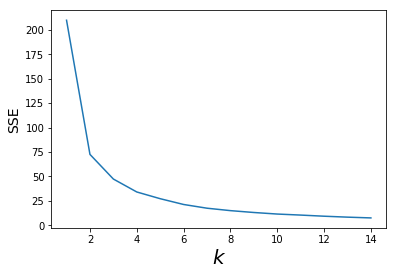

In [69]:
sse=kmeans_SSE(df_without_outliers)

Il est préférable de choisir entre 2 et 4 clusters, c'est ce nombre qui dimineu le plus la SSE et ensuite elle diminue plus lentement.

##### Silhouette

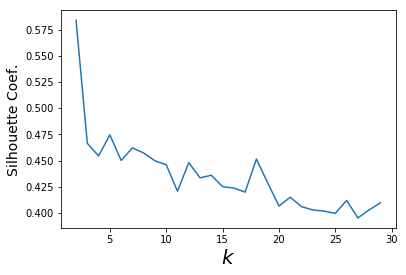

In [40]:
silhouette_kmeans(df_without_outliers)

Ici on ne voit pas de pics "clairs" du coefficient Silhouette. Le max local intéressant peut être celui à 5 clusters car il est dans la plage qui correspond à la forte baisse de SSE.

**Pour l'algorithme de Kmeans, on fixera donc le nombre de clusters à 5.**

In [31]:
km = KMeans(n_clusters=5) # create a KMeans object
km.fit(df_without_outliers)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

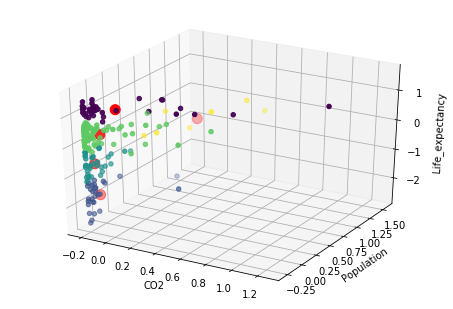

In [32]:
plot_km3d(km,df_without_outliers)

Les 5 clusters trouvés se différencient principalement par l'espérance de vie : on retrouve des points à tous les niveaux d'espérance de vie et de CO2 dans chaque cluster.

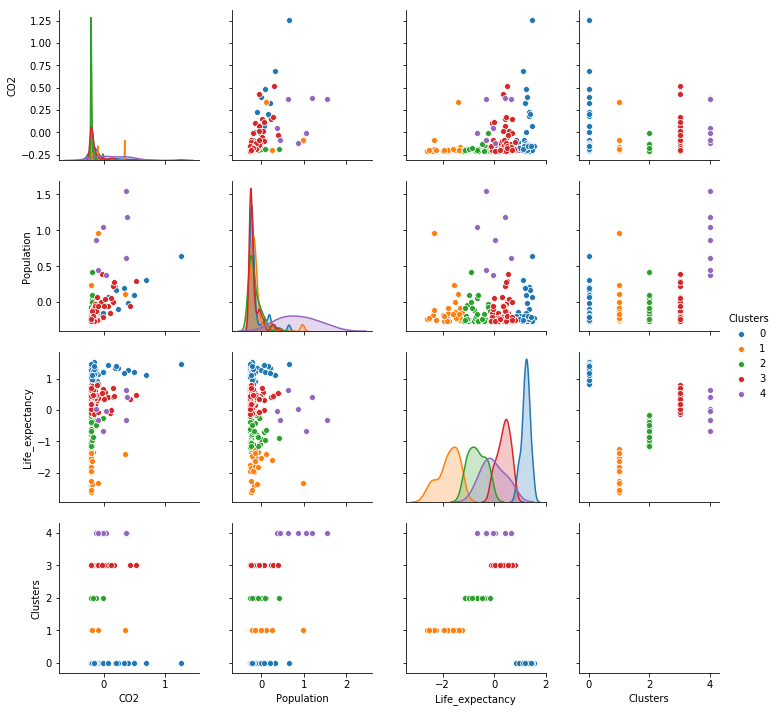

In [38]:
df_kmeans_labels=df_without_outliers.copy()
df_kmeans_labels['Clusters']=km.labels_
s=sns.pairplot(data=df_kmeans_labels,hue='Clusters')

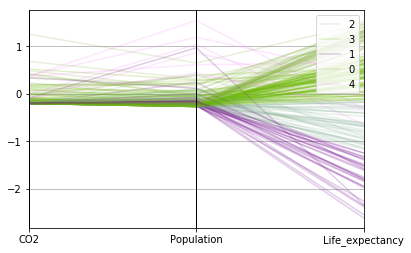

In [127]:
parallel_coordinates(df_kmeans_labels,'Clusters', alpha=0.2)
plt.show()

On remarque que l'espérance de vie est caractéristique d'un groupe. 
Ici, les clusters sont elliptiques et donc les groupes sont difficiles à trouver.
Cependant la population et le CO2 semble corrélés, et nous allons le vérifier dans Kmeans2. ???Comment tu vois ça ?

### Clustering hiérarchique

On fait d'abord le clustering sur les données avec outliers.

In [46]:
aco = AgglomerativeClustering(affinity="euclidean", linkage="complete")
aco.fit(df_clustering_red)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=2, pooling_func=<function mean at 0x10f486aa0>)

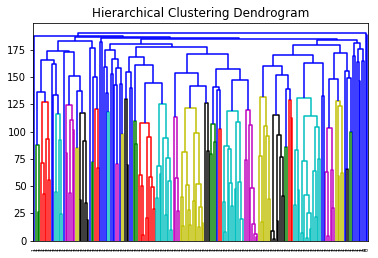

In [47]:
plt.title('Hierarchical Clustering Dendrogram')
plot_sklearn_dendrogram(aco,labels=aco.labels_)
plt.show()

Par défaut, l'algorithme fait deux clusters.

#### Troncature du dendrogramme

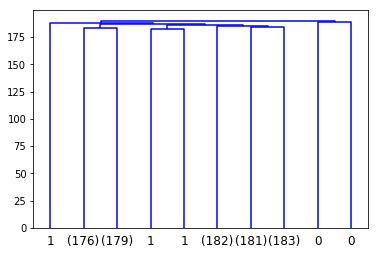

In [44]:
trunc=10
plot_sklearn_dendrogram(ac, labels=ac.labels_, truncate_mode='lastp', p=trunc)

Le clustering agglomératif met en évidence 3 points isolés. Ce sont certainement 3 des outliers déterminés à la partie 1.

### Clustering hiérarchique sur données sans outliers

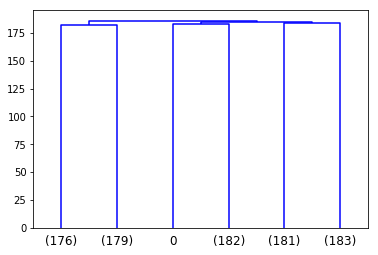

In [61]:
acwo = AgglomerativeClustering(affinity="euclidean", linkage="complete")
acwo.fit(df_without_outliers)
trunc=6
plot_sklearn_dendrogram(acwo, labels=acwo.labels_, truncate_mode='lastp', p=trunc)

On remarque que les clusters de un pays ont disparu : c'étaient bien les outliers. Pour ce clustering, on va choisir 5 clusters car les courbes de SSE et de coefficient silhouette suggèrent cela pour nos données.

In [57]:
ac = AgglomerativeClustering(affinity="euclidean", linkage="complete",n_clusters=5)
ac.fit(df_without_outliers)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=5, pooling_func=<function mean at 0x10f486aa0>)

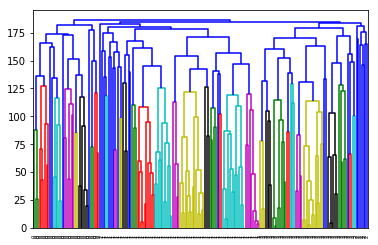

In [58]:
plot_sklearn_dendrogram(ac, labels=ac.labels_)

## DBSCAN

Au vu des différences de densité entre nos points, on peut penser que DBSCAN ne donnera pas de bons résultats.
La diffilcuté sera de déterminer les paramètres eps et min_samples...

Pour ne pas avoir trop de clusters (rappelons-nous qu'idéalement, il en faut 5 pour diminuer la SSE), on choisit une valeur de min_samples assez grande. Ici, on choisit 10 (c'est-à-dire qu'on nepeur ps former des clusters de moins de 10 pays).

_Remarque : on aurait bien aimé choisir min samples plus grand : mais alors DBSCAN ne fait qu'un cluster la plupart du temps !_

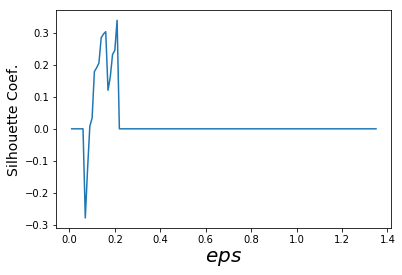

In [123]:
silhouette_dbscan(df_without_outliers,10,mean_dist_knee)

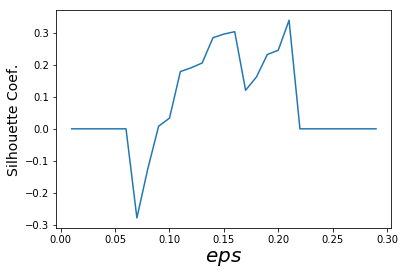

In [124]:
silhouette_dbscan(df_without_outliers,10,0.3)

D'après ce graphe, pour min_samples=10, on doit choisir eps égal à 0,15. C'est cohérent car inférieur à mean_dist_knee=1,3.

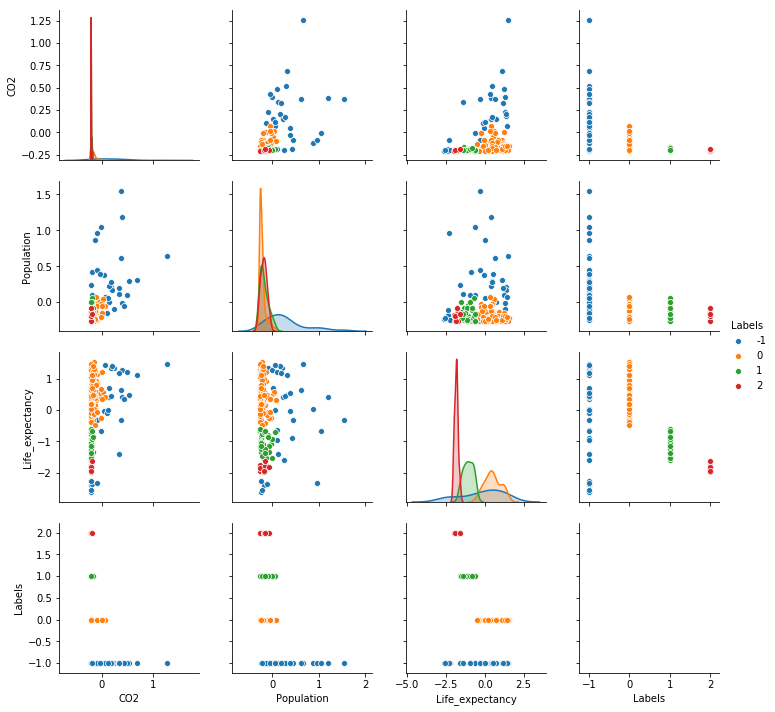

In [122]:
db=DBSCAN(min_samples=10,eps=.21).fit(df_without_outliers)
df_clustering_wo_lab=df_without_outliers.copy(deep=True)
df_clustering_wo_lab['Labels']=db.labels_
s=sns.pairplot(data=df_clustering_wo_lab,hue='Labels') # les labels ne nous servent pas

L'algorithe trouve 3 clusters et beaucoup de points sont considérés comme "noise points".
On remarque que comme dans le cas de Kmeans, l'espérance de vie est un facteur discriminant.

## Comparaison des 3 clusterings

Pour comparer les clusterings, comme on n'a pas de classe de référence, on ne peut pas utiliser d'index externe.
par contre, on peut utiliser des mesures internes (coefficient silhouette) pour comparer les clusterings entre eux.

### Coefficient silhouette

In [131]:
skm=silhouette_score(df_without_outliers, km.labels_, metric='euclidean', sample_size=None)
sac=silhouette_score(df_without_outliers, ac.labels_, metric='euclidean', sample_size=None)
sdb=silhouette_score(df_without_outliers, db.labels_, metric='euclidean', sample_size=None)
print("Silhouette score for kmeans : {0}, for agglomerative clustering = {1}, for DBSCAN : {2}".format(skm,sac,sdb))

Silhouette score for kmeans : 0.476242267131, for agglomerative clustering = 0.443756877887, for DBSCAN : 0.338384142828


Le clustering qui sépare le mieux les données est Kmeans.

On pourrait ensuite comparer les valeurs de coefficient silhouette obtenus avec nos clusterings à des clusterings sur données aléatoires, et faire une étude statistique pour voir si la mesure est significative d'un "bon" clustering.

## Analyse des clusterings

### Stabilité

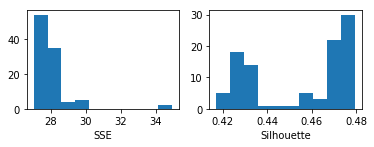

In [41]:
stability_kmeans(df_without_outliers,5)

Pour 5 clusters, l'algorithme de Kmeans est plutôt instable puisque les valeurs de SSE et de coefficient silhouette ne sont pas mes mêmes si on répète plusieurs fois le clustering.

#### Stabilité avec différents nombres de clusters

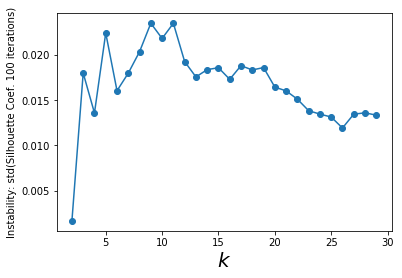

In [48]:
plot_stability(df_without_outliers)

Kmeans est particulièrement instable autour des 5 clusters choisis... 

# Kmeans 2


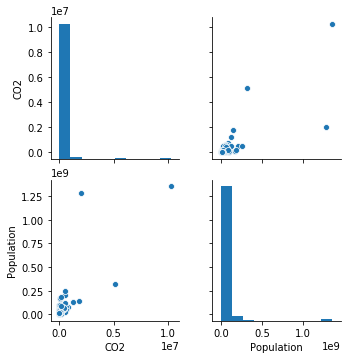

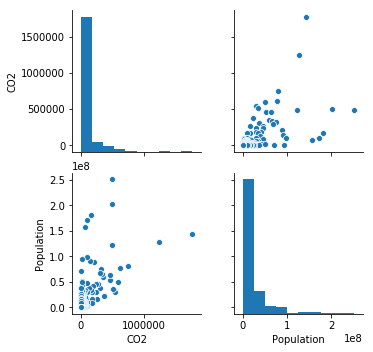

In [44]:
DF_kmeans2 = filtered_df[['CO2'  , 'Population' ]] 
dfScatterPlot = sns.pairplot(data=DF_kmeans2)

DF_kmeans2 = DF_kmeans2.sort_values(by =['CO2'] , ascending = False)[3: ][ : ] # Remove Outliers
dfScatterPlot = sns.pairplot(data=DF_kmeans2)

In [45]:
km2 = KMeans(n_clusters=3) # create a KMeans object
km2.fit(DF_kmeans2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

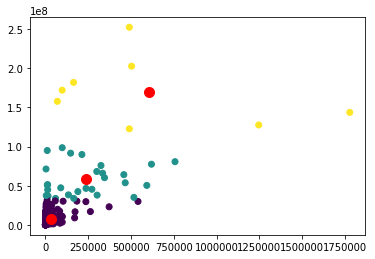

In [46]:
plt.scatter(data=DF_kmeans2, x="CO2", y="Population" , c=km2.labels_.astype(np.float))
plt.scatter(km2.cluster_centers_[:,0],km2.cluster_centers_[:,1],c='red',s=100)


On observe d'après ce graphique les limites du Kmeans 

### Vision d'ensemble des données

## Contingence DBSCAN et KMEAN

In [49]:
df_GDP = pds.read_csv('./Data_GDP/Data_GDP.txt', sep="\t") # load a pandas dataframe from csv

df_without_outliers.index

Index([u'0', u'1', u'2', u'5', u'6', u'7', u'8', u'9', u'10', u'11',
       ...
       u'205', u'207', u'208', u'209', u'210', u'211', u'213', u'214', u'215',
       u'216'],
      dtype='object', length=188)

Nous utiserons la GDP comme classe étiquette

# Arbre de décision -> enveloppe des cluster

In [50]:
Tree_enveloppe = df_without_outliers.copy(deep=True)
Tree_enveloppe['Labels']=kmdb.labels_
classes=Tree_enveloppe['Labels']
features=Tree_enveloppe.drop('Labels',axis=1)

In [51]:
model  = DecisionTreeClassifier(criterion = 'entropy') # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
model.fit(features , classes)
sortedLabelList = ['0', '1', '2']

In [64]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features.columns,  
                         class_names=(sortedLabelList),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

#  Arbre de décision sur CO2

In [65]:
def kmeans_1D(attribute,n):
    """Prend en entrée un nparray et n clusters"""
    km1 = KMeans(n_clusters=n) # create a KMeans object
    km1.fit(V_Life_expectancy.reshape(-1,1))
    return km1

In [54]:
def plot_pred_nbclusters(attr):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at =attr
    x_ind = range(0, len(at))
    plt.hist(at )
    plt.show()

In [55]:
def plot_kmeans1D(attr,labels):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at = attr
    x_ind = range(0, len(at))
    plt.hist(at);

    plt.show()

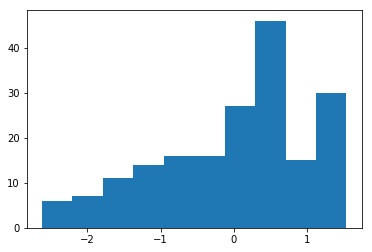

In [57]:
V_Life_expectancy  = np.array(df_without_outliers['Life_expectancy'])
plot_pred_nbclusters(V_Life_expectancy)
KM_LE = kmeans_1D(V_Life_expectancy , 3)

#plot_kmeans1D(V_Life_expectancy,KM.labels_)

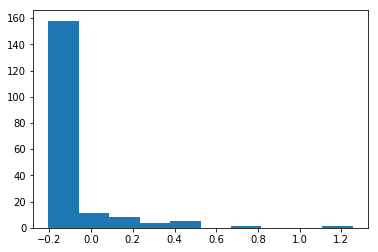

NameError: name 'KM' is not defined

In [58]:
V_CO2  = np.array(df_without_outliers['CO2'])
plot_pred_nbclusters(V_CO2)
KM_CO2 = kmeans_1D(V_CO2 , 2)

plot_kmeans1D(V_CO2,KM.labels_)

# Arbre de décision avec classe en fonction des sorties de Kmeans LE

In [60]:
Tree_LE = df_without_outliers.copy(deep=True)
Tree_LE['Labels']=KM_LE.labels_
classes=Tree_LE['Labels']
features=Tree_LE.drop('Labels',axis=1)
Tree_LE =Tree_LE.drop('Life_expectancy',axis=1)

model  = DecisionTreeClassifier(criterion = 'entropy') # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
clf = model.fit(features , classes)
sortedLabelList = ['0', '1', '2']

In [66]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=Tree_LE.columns,  
                         class_names=sortedLabelList,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH